In [1]:
import response
import map_tree
import region_of_interest
import ROOT
import healpy as hp
import astropy.units as u
import numpy as np
import partial_image_to_healpix
import psf_fast
import matplotlib.pyplot as plt

%matplotlib notebook
%load_ext line_profiler

Configuration read from /home/giacomov/.threeML/threeML_config.yml
Plotter is MatPlotlib


In [2]:
r = response.HAWCResponse("/home/giacomov/science/hawc/data/response.root")

psf = r.response_bins[50][0].psf

In [3]:
def test():
    
    bah = map(lambda x:psf.point_source_image(1024, 0.0, 0.0), range(10))

%lprun -f psf._get_point_source_image_aitoff test()

#%prun r.analysis_bins[50][9].psf.point_source_image(1024, 0.0, 0.0)

In [4]:
%timeit psf.point_source_image(1024, 0.0, 0.0)

1 loop, best of 3: 457 ms per loop


In [13]:
healpix_img = psf.point_source_image(1024, 125, 40.0)

print np.isfinite(healpix_img.to_dense()).sum()

215550


<IPython.core.display.Javascript object>


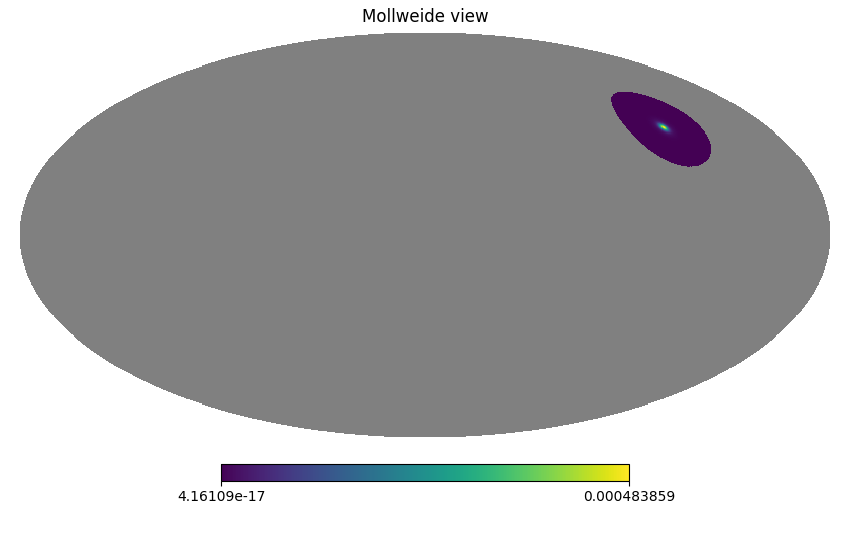


WARNING RuntimeWarning: invalid value encountered in less_equal


WARNING RuntimeWarning: invalid value encountered in less_equal



In [14]:
hp.mollview(healpix_img.to_dense(), flip='geo')

In [9]:
import psf
import psf_old

tf1 = r.analysis_bins[50][9].psf._tf1

psf1 = psf.TF1Wrapper(tf1)
psf2 = psf_old.TF1Wrapper(tf1)

In [19]:
%prun map1 = psf1.point_source_image(2048, 0.0, 0.0)

In [20]:
%prun map2 = psf2.point_source_image(2048, 0.0, 0.0)

In [21]:
print np.sum(map2[map2 != hp.UNSEEN])
print np.sum(map1[map1 != hp.UNSEEN])

1.0
1.0


8.818262579e-05
0.0079166752266


<IPython.core.display.Javascript object>


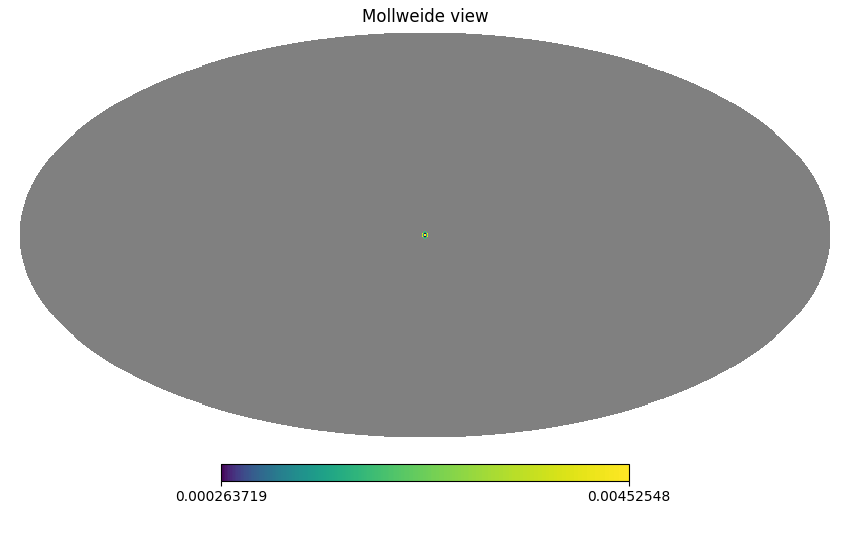

In [23]:
mm1 = map1.to_dense()

idx1 = mm1 != hp.UNSEEN
idx2 = map2 != hp.UNSEEN
idx = idx1 & idx2 & (mm1 > 1e-8)

ratio = np.zeros(map2.shape) + hp.UNSEEN

ratio[idx] = np.abs(mm1[idx] - map2[idx]) / map2[idx]

print ratio[idx].min()
print ratio[idx].max()

hp.mollview(ratio, norm='log')

<IPython.core.display.Javascript object>


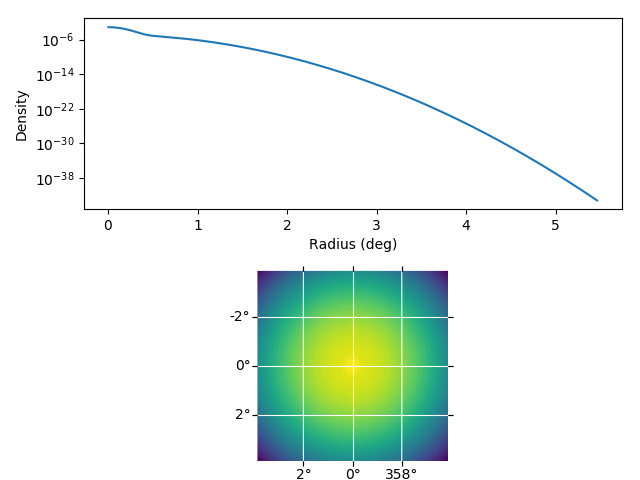

Min: 7.5310545317e-40
Max: 7.5470888374


In [8]:
_, header = psf2.plot()

In [13]:
psf = r.analysis_bins[50][0].psf

%timeit psf._tf1.Integral(0.0, 0.1, psf._tf1.GetParameters(), 1e-3)

The slowest run took 11.10 times longer than the fastest. This could mean that an intermediate result is being cached.
100000 loops, best of 3: 6.29 µs per loop


In [23]:
hp.nside2resol(1024, arcmin=True) / 60.0

0.057258106863623433

In [3]:
# %timeit (r.analysis_bins[50][0].psf.integral(0, 10))

# print(r.analysis_bins[50][0].psf.integral(0, 10))

In [3]:
ra_crab, dec_crab = 83.633083, 22.014500

roi = region_of_interest.HealpixConeROI(5.0, ra=ra_crab, dec=dec_crab)

m = map_tree.MapTree("/home/giacomov/science/hawc/data/maptree_1024.root", roi=roi)

In [4]:
m.display()

,Bin,Nside,Scheme,Obs counts,Bkg counts,obs/bkg,Pixels in ROI,Area (deg^2)
0,0,1024,RING,2.359288e+09,2.358957e+09,1.000141,23947,78.510019
1,1,1024,RING,1.563526e+08,1.562712e+08,1.000521,23947,78.510019
2,2,1024,RING,5.008916e+07,5.004267e+07,1.000929,23947,78.510019
3,3,1024,RING,1.370908e+07,1.367816e+07,1.002261,23947,78.510019
4,4,1024,RING,1.748741e+06,1.737266e+06,1.006605,23947,78.510019
5,5,1024,RING,3.882100e+05,3.829631e+05,1.013701,23947,78.510019
6,6,1024,RING,7.008800e+04,6.834725e+04,1.025469,23947,78.510019
7,7,1024,RING,4.146500e+04,4.048585e+04,1.024185,23947,78.510019
8,8,1024,RING,1.119500e+04,1.084205e+04,1.032553,23947,78.510019
9,9,1024,RING,1.546200e+04,1.503629e+04,1.028312,23947,78.510019


Total data size: 1.91576 Mbyte


In [12]:
mymap = m[1].observation_map.as_dense()

idx = (mymap != map_tree.UNSEEN)

for this_map in m[2:]:
    
    mymap[idx] += this_map.observation_map.as_dense()[idx]

idx = np.isnan(mymap)
mymap[idx] = hp.UNSEEN
    
mymap_smooth = hp.smoothing(mymap, (0.5 * u.deg).to(u.rad).value, iter=0)

Sigma is 12.739827 arcmin (0.003706 rad) 
-> fwhm is 30.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin


<IPython.core.display.Javascript object>


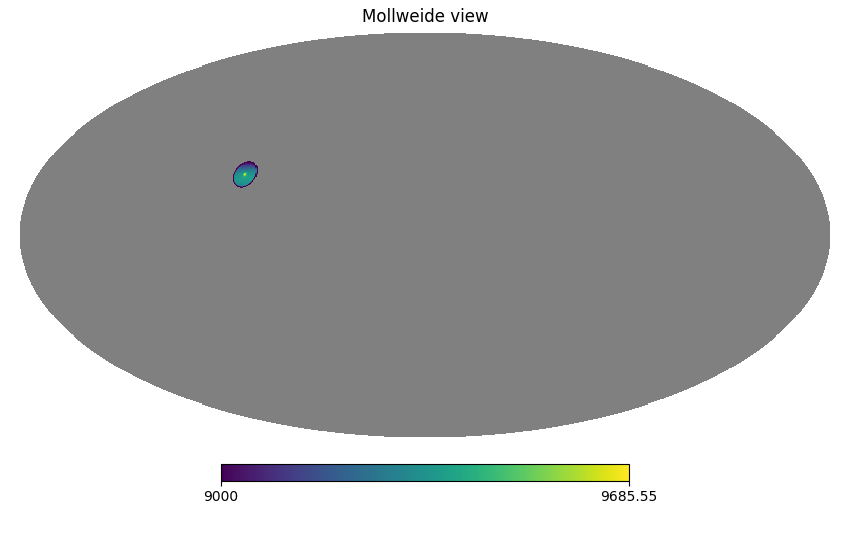

In [14]:
hp.mollview(mymap_smooth, flip='astro', norm='log', min=9000.0)

In [10]:
# 51 s full sky

masked = np.ma.masked_array(mymap, mask=mask)

In [11]:
np.sum(masked)

11210.0

In [30]:
hp.nside2npix(1024) / 1e7

1.2582912

In [32]:
np.sqrt(hp.nside2npix(1024))

3547.2400539010605

In [33]:
4000 * 3000

12000000